<div style="text-align: center;">
    <a href="https://www.dataia.eu/">
        <img border="0" src="https://github.com/ramp-kits/template-kit/raw/main/img/DATAIA-h.png" width="90%"></a>
</div>

# Template Kit for RAMP challenge

<i> Thomas Moreau (Inria) </i>

## Introduction

<p style="text-align: justify;">
    At the start of the year, the Court of Auditors published its report on the evaluation of the Skills Investment Plan, implemented during Emmanuel Macron’s first term from 2017 to 2022. This plan allocated 15 billion euros over five years to tackle youth and long-term unemployment. However, the report highlights an uneven distribution of funds across regions and years, with some areas receiving surplus funding while others faced shortages. <br>
</p>
<p style="text-align: justify;">
    Our project proposes <b>a solution for reallocating resources annually based on predicted funding needs at the departmental level. </b> Indeed, at the end of each year N-1, we aim to forecast the number of young job seekers for year N. This prediction will help the State better assess the potential regional needs for training funding, as it must depend on the number of unemployed individuals. Thus this result would help optimize the allocation of financial resources between regions and improve the efficiency of future public policies. <br>
</p>
<p style="text-align: justify;">
    For this project, we chose to focus on young job seekers at the departmental level. Our target variable will therefore be: <b>"the number of job seekers under 25yo in department D for year N".</b> To build this prediction, we rely on the Workforce Needs Survey conducted by France Travail in the last quarter of each year. This survey collects data from 2 million private-sector companies, asking about their expected job creations for the coming year and the challenges they anticipate in filling these positions (such as skill shortages or job difficulty). In addition, we will integrate other key indicators from year N-1, including the number of job postings, completed training programs, and control variables like the department’s population.
</p>



## Dataset Description

<p style="text-align: justify;">
This dataset is designed to predict youth unemployment (ages 15-24) in France using indicators from the French labor market. The data comes from <i>France Travail</i>, specifically from <i>the Statistiques et Analyses</i> section, covering the period from 2015 to 2023.
</p>

### The dataset includes the following key features:

- Year
- Department
- Number of workforce needs declared by companies, indicating recruitment demand across different sectors for this year and department.
- Recruitment difficulty index (0-100%), showing the percentage of difficulty companies face when hiring for this year and by department.
- Number of unemployed youth (15-24 years old) in France for the **previous** year and by department.
- Number of training programs offered for job seekers for the previous year and by department, providing insights into workforce skill development.
- Number of job offers available for the previous year and by department, reflecting labor market demand.
- Number of people entering and exiting the unemployment lists in France for the previous year and by department, providing a dynamic view of job market inflows and outflows.
- The size of the population for the previous year and by department (*Insee*).

# Exploratory data analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import math
pd.set_option('display.max_columns', None)

# Load the data
import problem
X_df, y = problem.get_train_data()

### Load the data

This dataset contains 8 years of data (from 2015 to 2022) on unemployment figures across various departments in France. It includes information on job offers, recruitment difficulties, manpower needs, and other socio-economic variables, with a focus on the number of unemployed individuals (OBS_VALUE) per department. Each record corresponds to a specific department for a given year, providing insights into the local labor market and employment dynamics.

First we look at the data.

In [2]:
df = pd.concat([X_df, y], axis=1)
df

,TIME_PERIOD,GEO,number_courses,job_offer,need_for_manpower,difficult_recruitment,out_of_list,entry_on_list,population,OBS_VALUE
0,2015,01,296.666667,4712.5,11760.0,37.0,1904800,1999900,631877,7440.833333
1,2015,02,441.666667,3810.0,11130.0,26.0,1904800,1999900,538659,11160.833333
2,2015,03,279.166667,2655.0,6730.0,38.0,1904800,1999900,341613,5078.333333
3,2015,04,158.333333,1182.5,7640.0,29.0,1904800,1999900,161799,2411.666667
4,2015,05,134.166667,1597.5,8960.0,28.0,1904800,1999900,140916,1920.833333
...,...,...,...,...,...,...,...,...,...,...
739,2022,91,2250.000000,10437.5,43900.0,48.0,2156200,2080500,1312419,12138.333333
740,2022,92,2396.666667,22240.0,85560.0,47.0,2156200,2080500,1637090,9466.666667
741,2022,93,3743.333333,12782.5,57430.0,43.0,2156200,2080500,1673645,18711.666667
742,2022,94,2357.500000,10320.0,48960.0,41.0,2156200,2080500,1420404,11540.833333


We have different types of features: numerical and categorical. We will need to preprocess them differently.

out_of_list and entry_on_list are categorical features which have only one value per year.

In [3]:
print("\nTypes : \n", df.dtypes)


Types : 
 TIME_PERIOD                int64
GEO                       object
number_courses           float64
job_offer                float64
need_for_manpower        float64
difficult_recruitment    float64
out_of_list                int64
entry_on_list              int64
population                 int64
OBS_VALUE                float64
dtype: object


There are no missing values.

In [4]:
print("\nMissing Values : \n", df.isnull().sum())


Missing Values : 
 TIME_PERIOD              0
GEO                      0
number_courses           0
job_offer                0
need_for_manpower        0
difficult_recruitment    0
out_of_list              0
entry_on_list            0
population               0
OBS_VALUE                0
dtype: int64


We then display the statistics of the dataset

In [5]:
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop(["TIME_PERIOD", "OBS_VALUE"])
stats = df.groupby('TIME_PERIOD')[numerical_cols].describe().loc[:, (slice(None), ['mean', 'std', 'min', 'max'])]
stats

number_courses                                        \
                      mean          std         min          max   
TIME_PERIOD                                                        
2015            442.405914   328.045140   75.833333  2155.000000   
2016            757.724014   564.560920  112.500000  3527.500000   
2017            599.883513   451.192593  105.000000  2869.166667   
2018            616.729391   457.149153   94.166667  2899.166667   
2019            711.559140   536.980579  100.833333  3510.000000   
2020            806.577061   670.472954   98.333333  3713.333333   
2021           1195.044803  1031.739718  134.166667  5360.833333   
2022           1138.154122   982.685349  135.833333  5401.666667   

                job_offer                               need_for_manpower  \
                     mean          std     min      max              mean   
TIME_PERIOD                                                                 
2015          7042.701613  7723.150808   660.0  51422.5      17702.956989   
2016          7527.029570  8230.417332   782.5  54132.5      18624.946237   
2017          8804.502688  9452.135767   947.5  61587.5      20113.870968   
2018          8748.252688  9236.817185   932.5  55367.5      23938.010753   
2019          8509.462366  8842.335193   922.5  54060.0      27477.580645   
2020          5938.561828  5695.450588   772.5  30497.5      30326.451613   
2021          8638.669355  8175.290662   957.5  48290.0      27724.731183   
2022         10492.983871  9939.200410  1017.5  58555.0      31062.956989   

                                            difficult_recruitment            \
                      std     min       max                  mean       std   
TIME_PERIOD                                                                   
2015         15590.582725  1430.0  100090.0             33.064516  5.062772   
2016         16955.181145  1380.0  111390.0             32.198925  4.317646   
2017         18384.108791  1890.0  120280.0             37.693548  5.122962   
2018         21953.674635  2680.0  142660.0             44.440860  6.144479   
2019         25734.428202  3140.0  173660.0             50.989247  6.004970   
2020         27919.310965  3650.0  176630.0             52.462366  5.736627   
2021         24396.367194  3270.0  147570.0             46.096774  6.574514   
2022         26829.185846  3410.0  160910.0             59.682796  6.904939   

                        out_of_list                            entry_on_list  \
              min   max        mean  std        min        max          mean   
TIME_PERIOD                                                                    
2015         22.0  47.0   1904800.0  0.0  1904800.0  1904800.0     1999900.0   
2016         22.0  42.0   2160300.0  0.0  2160300.0  2160300.0     2172000.0   
2017         27.0  49.0   2101700.0  0.0  2101700.0  2101700.0     2160900.0   
2018         29.0  57.0   2072900.0  0.0  2072900.0  2072900.0     2077300.0   
2019         33.0  62.0   2139700.0  0.0  2139700.0  2139700.0     2089700.0   
2020         38.0  65.0   1874400.0  0.0  1874400.0  1874400.0     1974600.0   
2021         33.0  59.0   2118300.0  0.0  2118300.0  2118300.0     1994800.0   
2022         41.0  72.0   2156200.0  0.0  2156200.0  2156200.0     2080500.0   

                                           population                 \
             std        min        max           mean            std   
TIME_PERIOD                                                            
2015         0.0  1999900.0  1999900.0  687066.978495  510111.814893   
2016         0.0  2172000.0  2172000.0  688837.795699  511881.395915   
2017         0.0  2160900.0  2160900.0  690619.290323  514222.810110   
2018         0.0  2077300.0  2077300.0  692784.548387  516898.611415   
2019         0.0  2089700.0  2089700.0  695480.903226  519828.680313   
2020         0.0  1974600.0  1974600.0  697299.139785  521224.841233   
2021         0.0

We now plot the distribution of each feature for two years: 2015 and 2022.
We specifically display every year for the target feature.

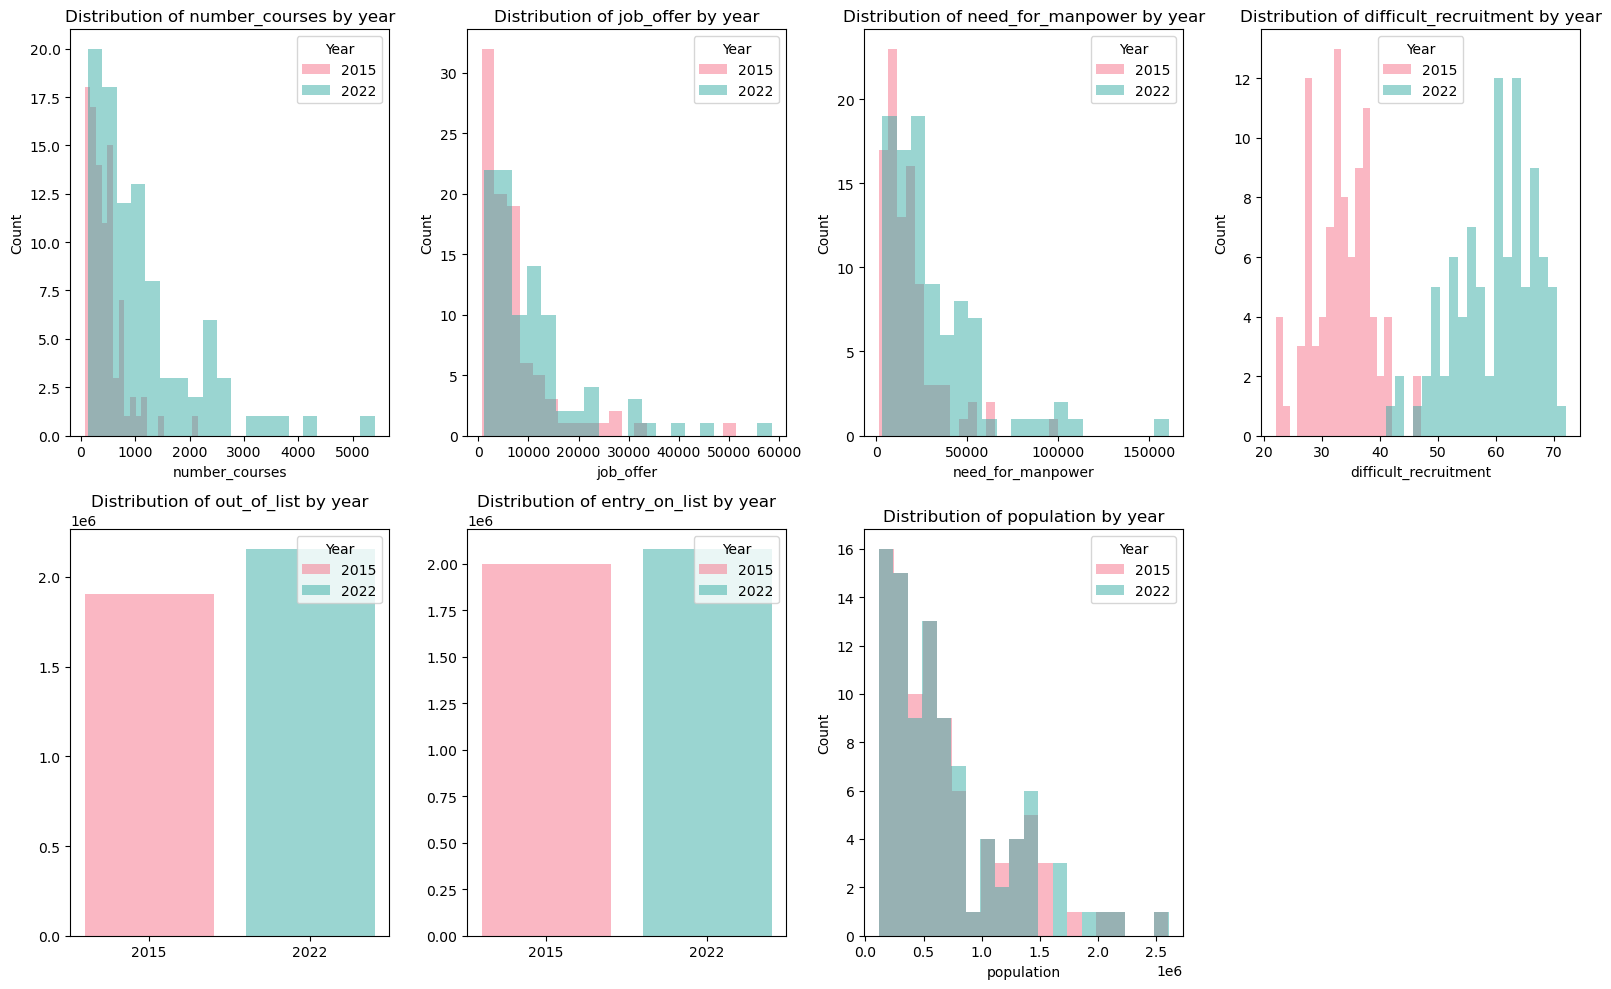

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

palette = sns.color_palette("husl", n_colors=2)  # Only two years (2015, 2022)
num_cols = len(numerical_cols)
rows = math.ceil(num_cols / 4)

fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(16, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    for j, year in enumerate([2015, 2022]):  # Plot only first and last year
        if col in ["out_of_list", "entry_on_list"]: # Only two unique values
            mean_value = X_df[X_df["TIME_PERIOD"] == year][col].mean()
            ax.bar(str(year), mean_value, color=palette[j], alpha=0.5, label=str(year))
        else:
            sns.histplot(X_df[X_df["TIME_PERIOD"] == year][col], bins=20, kde=False, 
                         color=palette[j], label=str(year), ax=ax, alpha=0.5, edgecolor=None)
    
    ax.set_title(f"Distribution of {col} by year")
    ax.legend(title="Year")

# remove empty subplots
for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

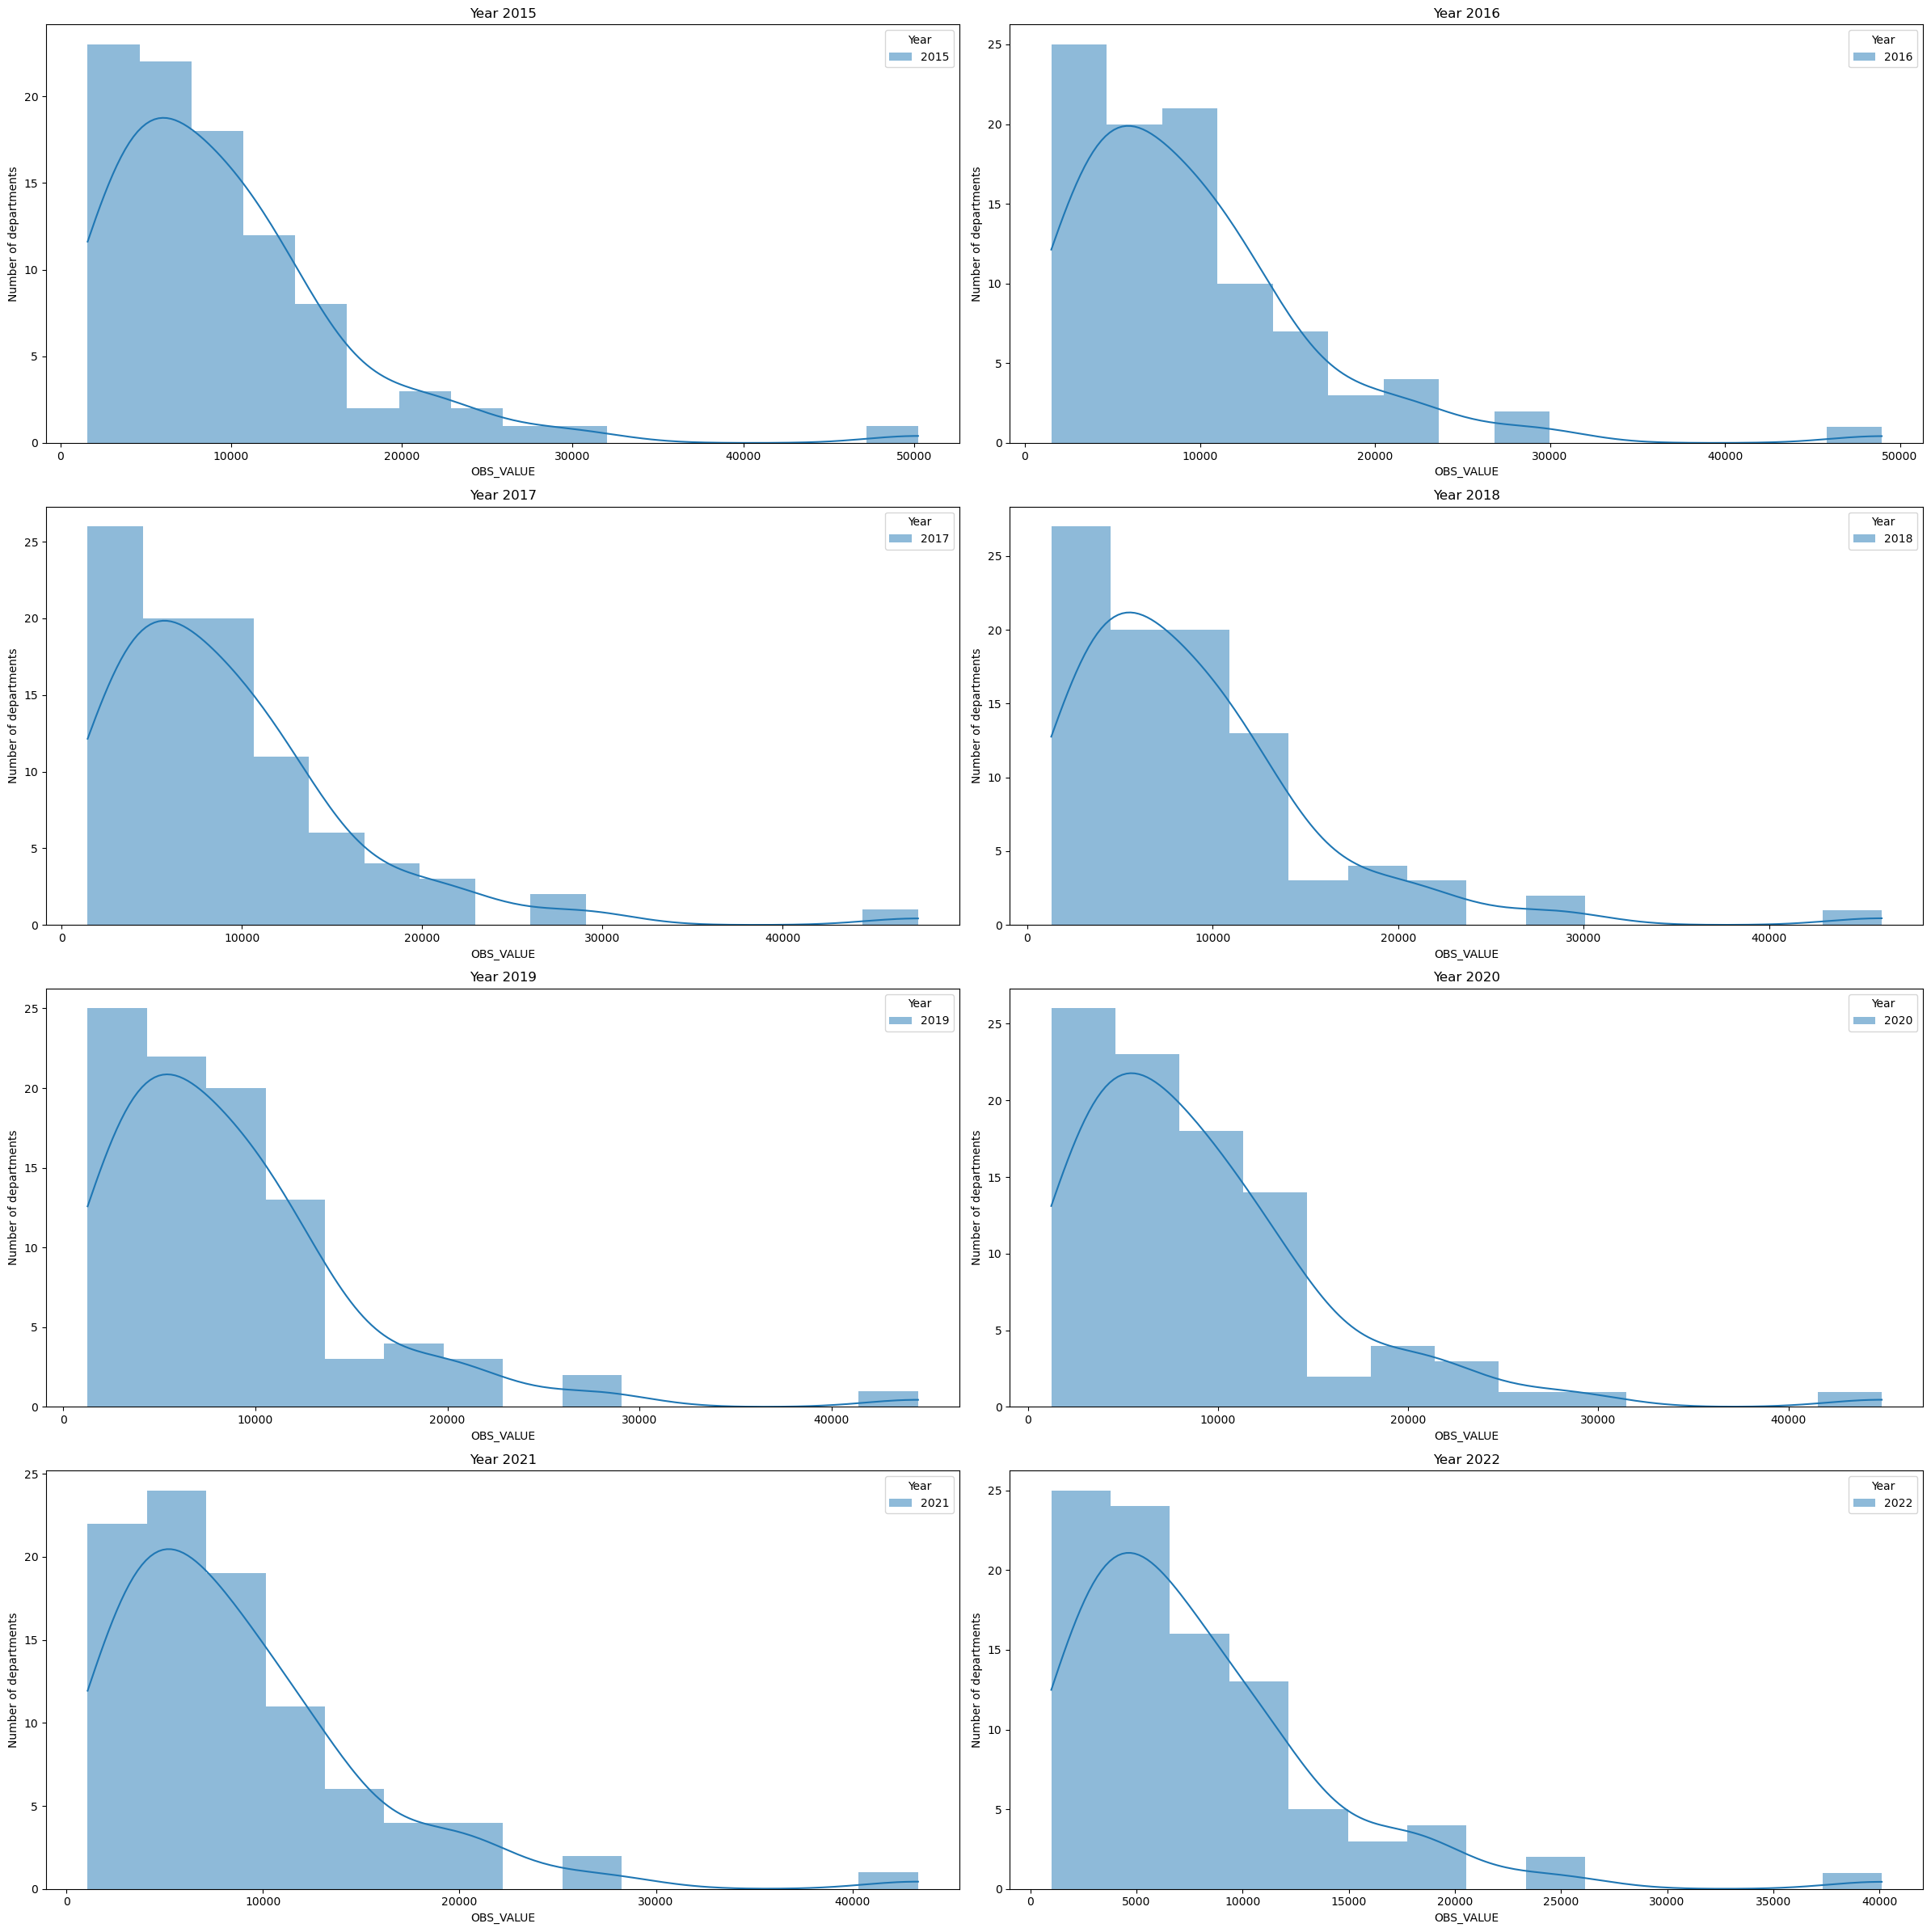

In [7]:
years = sorted(X_df["TIME_PERIOD"].unique())
num_years = len(years)

num_rows = 4
num_cols = math.ceil(num_years / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols, 6 * num_rows))
axes = axes.flatten()

for i, year in enumerate(years):
    sns.histplot(y[X_df["TIME_PERIOD"] == year], label=year, ax=axes[i], alpha=0.5, kde=True, edgecolor=None)
    axes[i].set_title(f"Year {year}")
    axes[i].legend(title="Year")
    axes[i].set_xlabel("OBS_VALUE")
    axes[i].set_ylabel("Number of departments")

for i in range(num_years, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Finally, we display of map of France, for each year with colors associated to the number of unemployed by department.
We can see that the department 59 (Nord) has the highest number of unemployed people for each year

Year 2015 : Max value 50239.166666666664 in department 59
Year 2016 : Max value 48960.833333333336 in department 59
Year 2017 : Max value 47505.833333333336 in department 59
Year 2018 : Max value 46067.5 in department 59
Year 2019 : Max value 44497.5 in department 59
Year 2020 : Max value 44905.0 in department 59
Year 2021 : Max value 43340.833333333336 in department 59
Year 2022 : Max value 40108.333333333336 in department 59


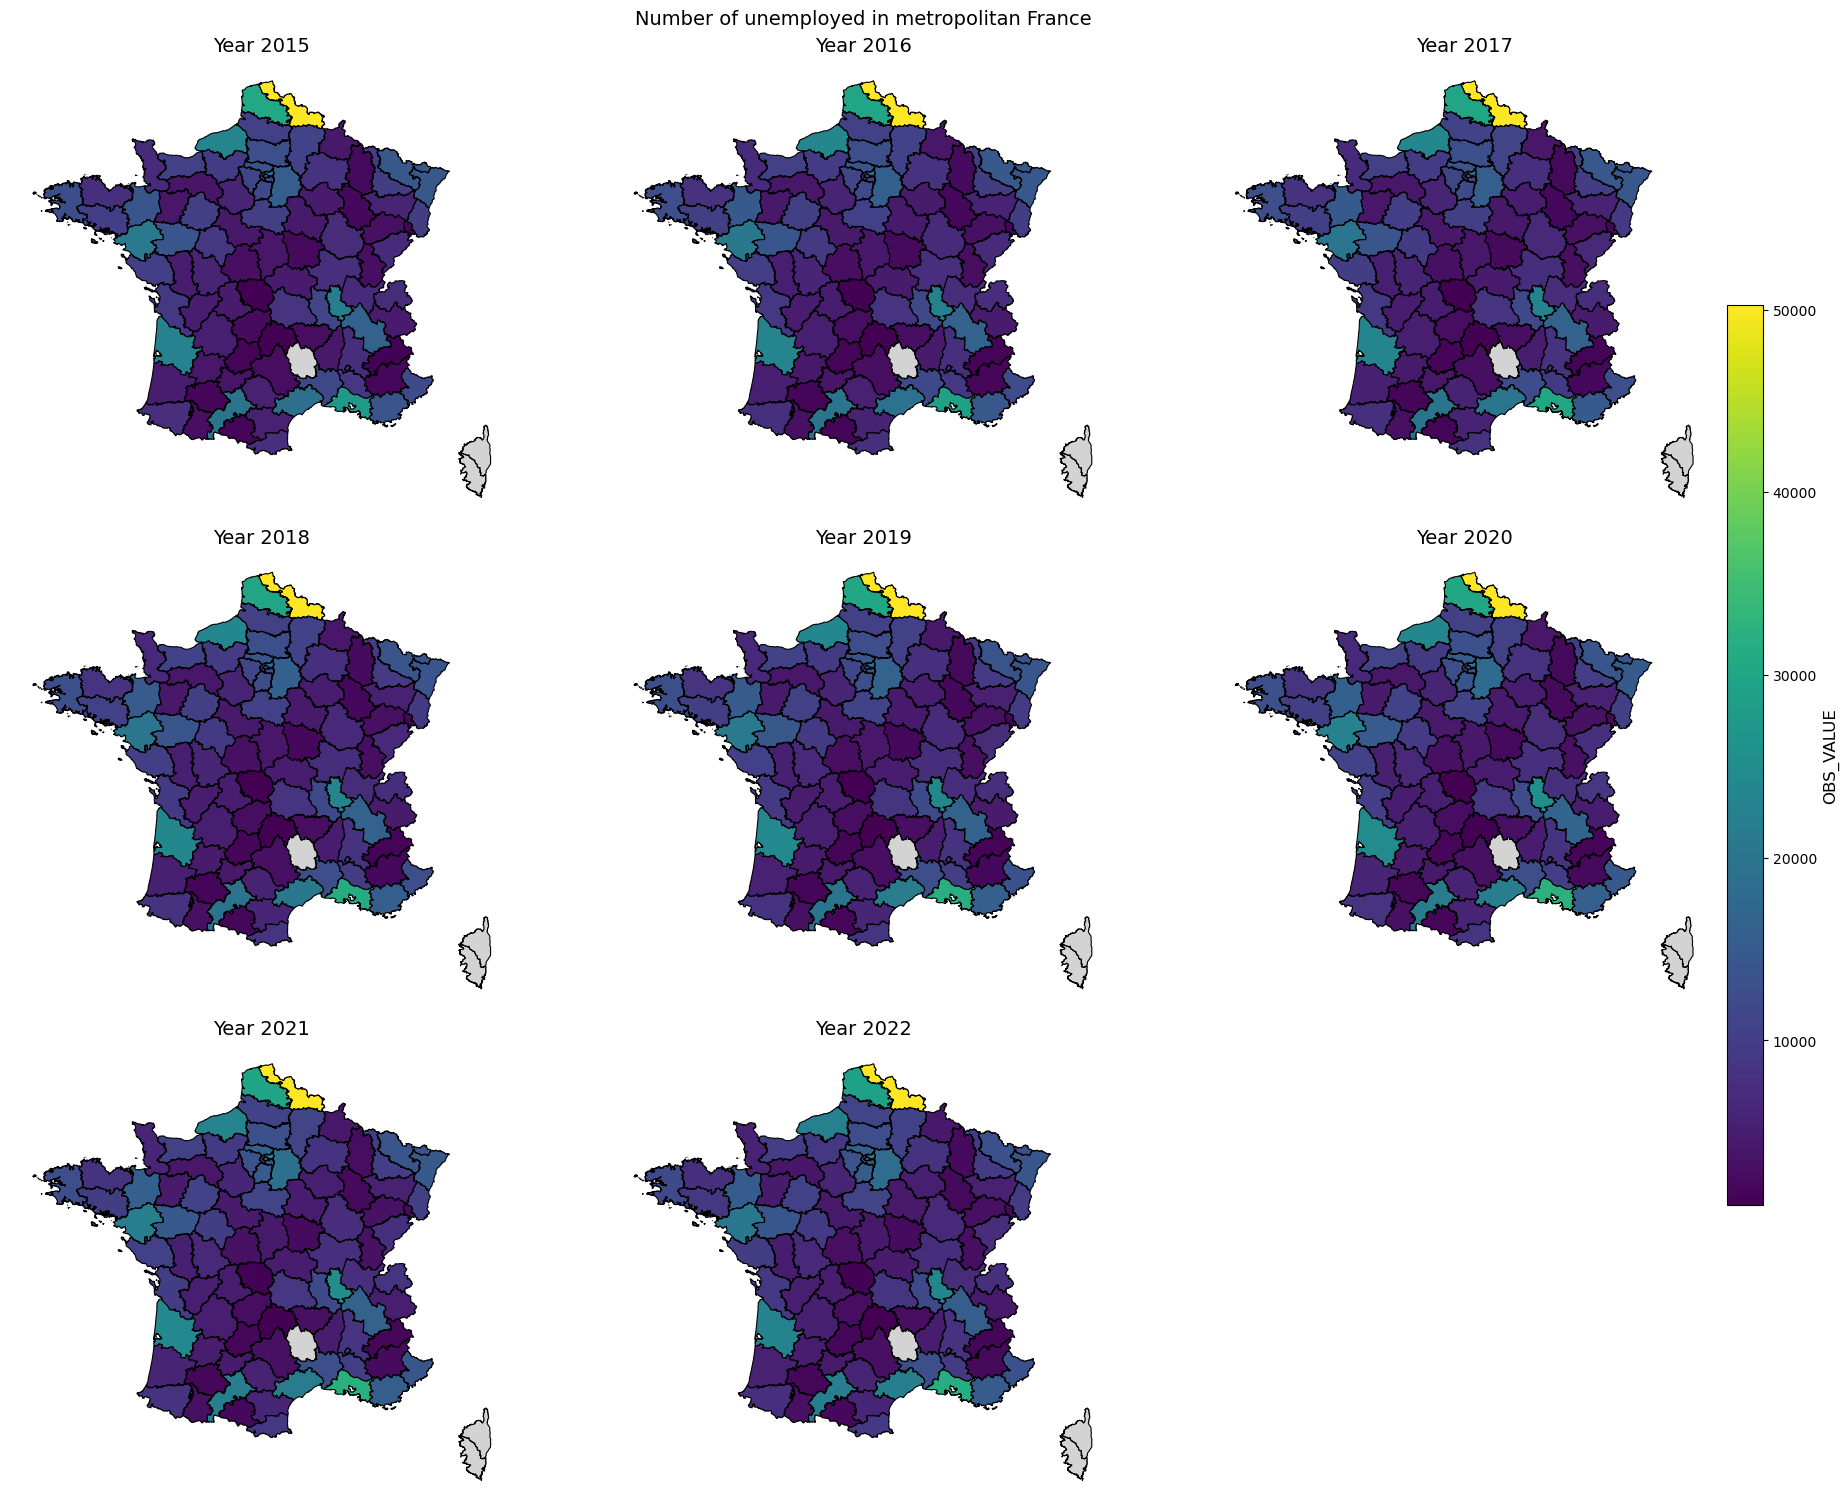

In [8]:
url_geojson = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson"
gdf = gpd.read_file(url_geojson)

years = sorted(df["TIME_PERIOD"].unique())
n_years = len(years)

cols = min(n_years, 3)
rows = math.ceil(n_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), constrained_layout=True)
axes = axes.flatten()

vmin = df["OBS_VALUE"].min()
vmax = df["OBS_VALUE"].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("viridis")

for ax, year in zip(axes, years):
    df_year = df[df["TIME_PERIOD"] == year]
    gdf_merged = gdf.merge(df_year, left_on="code", right_on="GEO", how="left")

    # Print maximum value and department code
    max_value = gdf_merged[gdf_merged["OBS_VALUE"] == gdf_merged["OBS_VALUE"].max()][["code", "OBS_VALUE"]].values[0]
    print(f"Year {year} : Max value {max_value[1]} in department {max_value[0]}")


    gdf_merged.plot(
        column="OBS_VALUE",
        cmap=cmap,
        linewidth=0.8,
        edgecolor="black",
        legend=False,
        ax=ax,
        missing_kwds={"color": "lightgrey"}
    )
    
    ax.set_title(f"Year {year}", fontsize=14)
    ax.axis("off")

for i in range(n_years, len(axes)):
    fig.delaxes(axes[i])

cbar_ax = fig.add_axes([0.98, 0.2, 0.02, 0.6])
cb = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(cb, cax=cbar_ax, orientation="vertical")
cbar.set_label("OBS_VALUE", fontsize=12)

plt.suptitle("Number of unemployed in metropolitan France", fontsize=14)
plt.show()

# Challenge evaluation

A particularly important point in a challenge is to describe how it is evaluated. This is the section where you should describe the metric that will be used to evaluate the participants' submissions, as well as your evaluation strategy, in particular if there is some complexity in the way the data should be split to ensure valid results.

# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [13]:
# %load submissions/starting_kit/estimator.py

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

cols = ['TIME_PERIOD', 'GEO', 'number_courses', 'job_offer',
       'need_for_manpower', 'difficult_recruitment', 'out_of_list',
       'entry_on_list', 'population']

categorical_cols = ['GEO', 'TIME_PERIOD']
numerical_cols = ['number_courses', 'job_offer',
       'need_for_manpower', 'difficult_recruitment', 'out_of_list',
       'entry_on_list', 'population']

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('passthrough', numerical_cols)
)

def get_estimator():
    pipe = make_pipeline(
        transformer,
        SimpleImputer(strategy='most_frequent'),
        RandomForestRegressor(n_estimators=50)
    )

    return pipe

In [14]:
from skrub import tabular_learner
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tabular_learner('regressor'), X_df, y, scoring='neg_median_absolute_error')
print(-scores)

[362.25196214 261.46333993 207.06763228 254.56361181 498.42648144]


## Testing using a scikit-learn pipeline

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(get_estimator(), X_df, y, cv=3, scoring='neg_median_absolute_error')
print(-scores)

[537.73333333 352.93333333 688.04166667]


In [16]:
X_df_test, y_test = problem.get_test_data()
scores = cross_val_score(get_estimator(), X_df_test, y_test, cv=3, scoring='neg_median_absolute_error')
print(-scores)

[686.5        701.76666667 750.73333333]


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).